In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

5


In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
60000/60000 [==============================] - 2s 40us/sample - loss: 0.2944 - acc: 0.9151
Epoch 2/5
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1423 - acc: 0.9571
Epoch 3/5
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1084 - acc: 0.9669
Epoch 4/5
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0866 - acc: 0.9733
Epoch 5/5
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0745 - acc: 0.9760
10000/10000 - 0s - loss: 0.0745 - acc: 0.9771


[0.07451104667726904, 0.9771]

In [17]:
test_img = x_train[0]

def get_label_confidence(image, model):
    pr = model.predict(image.reshape(1, 28, 28))
    image_class = model.predict_classes(image.reshape(1, 28, 28))
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))
   
get_label_confidence(test_img, model)

'Predicted 0 : 0.9999828'

In [18]:
image_probs = model.predict(test_img.reshape(1, 28, 28))
label = tf.one_hot(5, image_probs.shape[-1])
print(label)

Tensor("one_hot_19:0", shape=(10,), dtype=float32)


In [19]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model2.fit(x_train, y_train, epochs=5)
model2.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
60000/60000 [==============================] - 2s 41us/sample - loss: 0.2949 - acc: 0.9144
Epoch 2/5
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1463 - acc: 0.9567
Epoch 3/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1103 - acc: 0.9666
Epoch 4/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0890 - acc: 0.9733
Epoch 5/5
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0755 - acc: 0.9764
10000/10000 - 0s - loss: 0.0711 - acc: 0.9772


[0.07112746095946058, 0.9772]

In [305]:
sess = K.get_session()
x = x_train[2]
x = np.reshape(x, (1, 28, 28))
x_orig = x
x_adv = x
x_noise = np.zeros_like(x)

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [306]:
model1_initial = 'Model 1 - ' + get_label_confidence(x_adv, model)
model2_initial = 'Model 2 - ' + get_label_confidence(x_adv, model2)
print('Initial Results')
print(model1_initial)
print(model2_initial)

Initial Results
Model 1 - Predicted 4 : 0.9997043
Model 2 - Predicted 4 : 0.9993735


In [307]:
# Set variables
N = 2
epochs = 21
epsilon = 0.01
true_class = 4
target_class = 2
prev_probs = []
prev_probs2 = []
prev_adv = []

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 10)
    true = K.one_hot(true_class, 10)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1 * K.categorical_crossentropy(target, model.output) 
    loss2 = -1 * K.categorical_crossentropy(true, model2.output)
    grads = K.gradients(loss, model.input)
    grads2 = K.gradients(loss2, model2.input)
    
    grad1 = sess.run(grads, feed_dict={model.input:x})
    grad2 = sess.run(grads2, feed_dict={model2.input:x})
    grad11 = grad1[0][0].flatten()
    grad21 = grad2[0][0].flatten()
    cos = cosine_similarity(grad11, grad21)
    sim = np.arccos(cos) * 180 / np.pi
    
    # Get the sign of the gradient
    delta = K.sign(grads[0]) + K.sign(grads2[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon * delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x, model2.input:x})
    prev_adv.append(x_adv)
    preds = model.predict(x_adv)
    preds2 = model2.predict(x_adv)
        
    if(target_class == np.argmax(preds[0]) and true_class == np.argmax(preds2[0])):
        break

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])
    prev_probs2.append(preds2[0][target_class])

    if i%1 == 0:
        '''
        print('Epoch:', i, '\t', 'Model1', '\t', 'Targeted', target_class, ':', preds[0][target_class], 
              '\t', get_label_confidence(x_adv, model))
        print('Epoch:', i, '\t', 'Model2', '\t', 'Targeted', target_class, ':', preds2[0][target_class],
              '\t', get_label_confidence(x_adv, model2))
        print('L2 Norm:', np.linalg.norm(x_adv - x))
        '''
        print('Iteration:', i, '\t', 'Cosine Similarity:', round(cos, 7), '\t', 'Angle:', sim)
    
    x = x_adv

Iteration: 0 	 Cosine Similarity: -0.276487 	 Angle: 106.05065335587382
Iteration: 1 	 Cosine Similarity: -0.3881876 	 Angle: 112.8417738438341
Iteration: 2 	 Cosine Similarity: -0.6036131 	 Angle: 127.12910890815341
Iteration: 3 	 Cosine Similarity: -0.6722877 	 Angle: 132.2438824077391
Iteration: 4 	 Cosine Similarity: -0.7200437 	 Angle: 136.058092266706
Iteration: 5 	 Cosine Similarity: -0.7169286 	 Angle: 135.80148205958864
Iteration: 6 	 Cosine Similarity: -0.7309978 	 Angle: 136.97010010582113
Iteration: 7 	 Cosine Similarity: -0.6899436 	 Angle: 133.62565699758937
Iteration: 8 	 Cosine Similarity: -0.7417589 	 Angle: 137.88146590715428
Iteration: 9 	 Cosine Similarity: -0.6744926 	 Angle: 132.41474642001617
Iteration: 10 	 Cosine Similarity: -0.6432472 	 Angle: 130.0343845131317
Iteration: 11 	 Cosine Similarity: -0.7326547 	 Angle: 137.1094086441327
Iteration: 12 	 Cosine Similarity: -0.6907374 	 Angle: 133.68850839833183
Iteration: 13 	 Cosine Similarity: -0.7234188 	 Angle: 

In [308]:
model1_final = 'Model 1 - ' + get_label_confidence(x_adv, model)
model2_final = 'Model 2 - ' + get_label_confidence(x_adv, model2)
print('Final Results')
print('Iteration:', i)
print(model1_final)
print(model2_final)
print('L2 Norm:', np.linalg.norm(x_adv - x_orig))

Final Results
Iteration: 15
Model 1 - Predicted 2 : 0.6194932
Model 2 - Predicted 4 : 1.0000000
L2 Norm: 3.411568046344555


<Figure size 432x288 with 0 Axes>

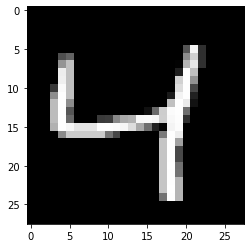

In [290]:
plt.set_cmap('Greys_r')
plt.figure()
plt.imshow(x_original)
plt.show()

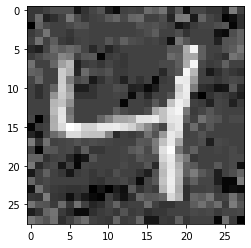

In [291]:
plt.imshow(x_adv[0])
plt.show()

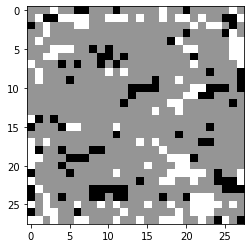

In [292]:
plt.imshow(x_adv[0] - x[0])
plt.show()